This script intends to do some overall media analysis

In [26]:
from dotenv import load_dotenv
import os, mediacloud.api
import datetime
import json
import pandas as pd 
from IPython.display import JSON
import mediacloud.tags
import csv
from tqdm import tqdm
import requests




In [2]:
# Setting up
mc = mediacloud.api.MediaCloud('439141f9647ae800fa099bf77e4297ea28fe3f2bbc2d64b1f2163ad52fd8fef2')
mediacloud.__version__

'3.12.5'

### Sources and Collections

In [13]:
matching_sources = mc.mediaList(name_like='MSNBC', sort='num_stories')
JSON(matching_sources)
[m['media_id'] for m in matching_sources]

[359084, 1149, 1551930, 1551932, 1551931, 1363107, 24743]

### Counting stories

In [14]:
# Set date range
start_date = datetime.date(2021,1,1)
end_date = datetime.date(2022,3,30)
date_range = mc.dates_as_query_clause(start_date, end_date) # default is start & end inclusive

# Right-wing media mentioning voter ID
q_right = '("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:1092 OR media_id:6443 OR media_id:101 OR media_id:7 OR media_id:19334 OR media_id:1150 OR media_id:18775 OR media_id:25649 media_id:1117)'
mc.storyCount(q_right, date_range)

{'count': 1042}

In [112]:
# check how many left-wing media mention voter ID
q_left = '("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:2 OR media_id:1 OR media_id:1149 OR media_id:1095 OR media_id:25499 OR media_id:4 OR media_id:104828 OR media_id:9 OR media_id:27502)'
mc.storyCount(q_left, date_range)

{'count': 563}

In [140]:
mc.storyCount('("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:2)', date_range)

{'count': 93}

In [143]:
def get_outlet_story_count(media_id):
    story_count = mc.storyCount(f'("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:{media_id})', date_range)
    return story_count

In [ ]:
results = []
for x in sources:
    story_counts = get_outlet_story_count(x)
    print(f"The media ID {x} has {story_counts} expected stories")

In [151]:
sources = [2, 1, 1149, 1095, 25499, 4, 104828, 9, 27502]
results = []
for x in sources:
    story_counts = get_outlet_story_count(x)['count']
    results.append(story_counts)

print(results)

[93, 98, 20, 143, 36, 42, 28, 4, 99]


In [165]:
a=list(zip(sources, results))
stories = pd.DataFrame(a, columns=['media_id', 'story_count'])
stories

,media_id,story_count
0,2,93
1,1,98
2,1149,20
3,1095,143
4,25499,36
5,4,42
6,104828,28
7,9,4
8,27502,99


In [166]:
stories['story_count'].sum()

563

In [ ]:
def get_outlet_story_count(mc, media_id, start_time, end_time):
     """
     Args:
         - mc (obj): a `mediacloud.api.MediaCloud` object already instantiated with the API key
         - media_id (str): Media Cloud's media source ID for the outlet (https://sources.mediacloud.org/#/sources/[media_id])
         - start_time (datetime)
         - end_time (datetime)

     Returns:
         - story_count (int)
     """
     date_range = mc.dates_as_query_clause(start_time, end_time-datetime.timedelta(days=1)) # default is start & end inclusive
     story_count = mc.storyCount(f'media_id:{media_id}', date_range)['count']
     return story_count

### Getting stories

In [16]:
# If we want to list ALL the stories matching, we need to page through the results. 
# This is accomplished via the last_processed_stories_id parameter. This code snippet pages through all the stories in a query.
def all_matching_stories(mc_client, q, fq):
    """
    Return all the stories matching a query within Media Cloud. Page through the results automatically.
    :param mc_client: a `mediacloud.api.MediaCloud` object instantiated with your API key already
    :param q: your boolean query
    :param fq: your date range query
    :return: a list of media cloud story items
    """
    last_id = 0
    more_stories = True
    stories = []
    while more_stories:
        page = mc_client.storyList(q, fq, last_processed_stories_id=last_id, rows=500, sort='processed_stories_id')
        print("  got one page with {} stories".format(len(page)))
        if len(page) == 0:
            more_stories = False
        else:
            stories += page
            last_id = page[-1]['processed_stories_id']
    return stories

In [17]:
# let's fetch all the stories matching our query (this can take a few minutes)
left = all_matching_stories(mc, q_left, date_range)
len(left)

  got one page with 463 stories
  got one page with 58 stories
  got one page with 0 stories


521

Writing a CSV of Story Data

In [20]:
# first flatten things a little bit to make writing a CSV easier
for s in left:
    # see the "language" notebook for more details on themes
    theme_tag_names = ','.join([t['tag'] for t in s['story_tags'] if t['tag_sets_id'] == mediacloud.tags.TAG_SET_NYT_THEMES])
    s['themes'] = theme_tag_names
# now write the CSV
fieldnames = ['stories_id', 'publish_date', 'title', 'url', 'language', 'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url']
with open('left.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction='ignore')
    writer.writeheader()
    for s in left:
        writer.writerow(s)

In [89]:
import pandas
left_corpus = pandas.read_csv('left.csv', encoding='cp1252')
len(left_corpus)
left_corpus.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,1813361379,2021-01-02 10:00:00,The U.S. needs a democracy overhaul. Here’s wh...,https://www.washingtonpost.com/opinions/the-us...,en,False,NaN,2,Washington Post,http://washingtonpost.com
1,1813641638,2021-01-03 00:12:49,Republican efforts to undermine Biden victory ...,http://rss.cnn.com/~r/rss/cnn_latest/~3/uWpq48...,en,False,NaN,1095,CNN,http://www.cnn.com/
2,1814219226,2021-01-03 23:21:39,Attorney On Trump’s Georgia Call Works With Gr...,https://www.huffpost.com/entry/cleta-mitchell-...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#
3,1814688041,2021-01-04 11:09:11,"In majority-Black Georgia county, voting in Se...",http://rss.cnn.com/~r/rss/cnn_latest/~3/rWPfMC...,en,False,NaN,1095,CNN,http://www.cnn.com/
4,1814917770,2021-01-04 17:07:25.947852,What you need to know about Brad Raffensperger,https://www.washingtonpost.com/politics/2021/0...,en,False,NaN,2,Washington Post,http://washingtonpost.com


In [118]:
domain = left_corpus['media_name'].value_counts()  #counting urls per news media source
pd.DataFrame(domain)

,media_name
CNN,136
New York Times,93
Washington Post,90
HuffPost,88
USA Today,35
NBC News,34
Vox,26
MSNBC,15
Chicago Tribune,4


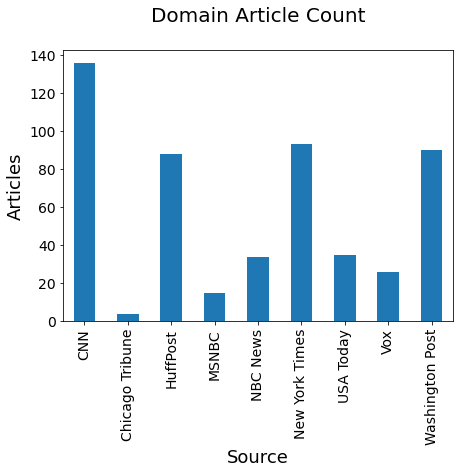

In [119]:
ax = domain.sort_index().plot(kind='bar', fontsize=14, figsize=(7,5)) # Counting articles per news source
ax.set_title('Domain Article Count\n', fontsize=20)
ax.set_xlabel('Source', fontsize=18)
ax.set_ylabel('Articles', fontsize=18);

In [90]:
# create list of urls from pandas dataframe
urls = left_corpus['url'].to_list()
len(urls)

521

In [91]:
left_corpus.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,1813361379,2021-01-02 10:00:00,The U.S. needs a democracy overhaul. Here’s wh...,https://www.washingtonpost.com/opinions/the-us...,en,False,NaN,2,Washington Post,http://washingtonpost.com
1,1813641638,2021-01-03 00:12:49,Republican efforts to undermine Biden victory ...,http://rss.cnn.com/~r/rss/cnn_latest/~3/uWpq48...,en,False,NaN,1095,CNN,http://www.cnn.com/
2,1814219226,2021-01-03 23:21:39,Attorney On Trump’s Georgia Call Works With Gr...,https://www.huffpost.com/entry/cleta-mitchell-...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#
3,1814688041,2021-01-04 11:09:11,"In majority-Black Georgia county, voting in Se...",http://rss.cnn.com/~r/rss/cnn_latest/~3/rWPfMC...,en,False,NaN,1095,CNN,http://www.cnn.com/
4,1814917770,2021-01-04 17:07:25.947852,What you need to know about Brad Raffensperger,https://www.washingtonpost.com/politics/2021/0...,en,False,NaN,2,Washington Post,http://washingtonpost.com


### Converting publish_date to datetime

In [ ]:
# checking type for publish_date
left_corpus.info()


In [93]:
# left_corpus.rename(columns={'publish_date': 'Date'}) #renaming date column
left_corpus['Date'] = pd.to_datetime(left_corpus['publish_date']) # converting publish_date to datetime

In [94]:
left_corpus['mnth_yr'] = left_corpus['Date'].apply(lambda x: x.strftime('%d %B, %Y')) # converting datetime to string with day, month, year
left_corpus['Date'] = pandas.to_datetime(left_corpus['mnth_yr']) # converting string to simplified datetime column
left_corpus.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,Date,mnth_yr
0,1813361379,2021-01-02 10:00:00,The U.S. needs a democracy overhaul. Here’s wh...,https://www.washingtonpost.com/opinions/the-us...,en,False,NaN,2,Washington Post,http://washingtonpost.com,2021-01-02,"02 January, 2021"
1,1813641638,2021-01-03 00:12:49,Republican efforts to undermine Biden victory ...,http://rss.cnn.com/~r/rss/cnn_latest/~3/uWpq48...,en,False,NaN,1095,CNN,http://www.cnn.com/,2021-01-03,"03 January, 2021"
2,1814219226,2021-01-03 23:21:39,Attorney On Trump’s Georgia Call Works With Gr...,https://www.huffpost.com/entry/cleta-mitchell-...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#,2021-01-03,"03 January, 2021"
3,1814688041,2021-01-04 11:09:11,"In majority-Black Georgia county, voting in Se...",http://rss.cnn.com/~r/rss/cnn_latest/~3/rWPfMC...,en,False,NaN,1095,CNN,http://www.cnn.com/,2021-01-04,"04 January, 2021"
4,1814917770,2021-01-04 17:07:25.947852,What you need to know about Brad Raffensperger,https://www.washingtonpost.com/politics/2021/0...,en,False,NaN,2,Washington Post,http://washingtonpost.com,2021-01-04,"04 January, 2021"


In [103]:
# fix data types
left_corpus['stories_id'] = left_corpus['stories_id'].astype('str')
left_corpus['media_id'] = left_corpus['media_id'].astype('str')
left_corpus.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,Date,mnth_yr,Date_string,exclude_dupe,exclude_no_date
0,1813361379,2021-01-02 10:00:00,The U.S. needs a democracy overhaul. Here’s wh...,https://www.washingtonpost.com/opinions/the-us...,en,False,NaN,2,Washington Post,http://washingtonpost.com,2021-01-02,"02 January, 2021",2021-01-02,False,False
1,1813641638,2021-01-03 00:12:49,Republican efforts to undermine Biden victory ...,http://rss.cnn.com/~r/rss/cnn_latest/~3/uWpq48...,en,False,NaN,1095,CNN,http://www.cnn.com/,2021-01-03,"03 January, 2021",2021-01-03,False,False
2,1814219226,2021-01-03 23:21:39,Attorney On Trump’s Georgia Call Works With Gr...,https://www.huffpost.com/entry/cleta-mitchell-...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#,2021-01-03,"03 January, 2021",2021-01-03,False,False
3,1814688041,2021-01-04 11:09:11,"In majority-Black Georgia county, voting in Se...",http://rss.cnn.com/~r/rss/cnn_latest/~3/rWPfMC...,en,False,NaN,1095,CNN,http://www.cnn.com/,2021-01-04,"04 January, 2021",2021-01-04,False,False
4,1814917770,2021-01-04 17:07:25.947852,What you need to know about Brad Raffensperger,https://www.washingtonpost.com/politics/2021/0...,en,False,NaN,2,Washington Post,http://washingtonpost.com,2021-01-04,"04 January, 2021",2021-01-04,False,False


In [104]:
# Find and remove duplicates or articles without a date
left_corpus['exclude_dupe'] = left_corpus.duplicated(subset=['title', 'url'])
left_corpus['exclude_no_date'] = left_corpus['publish_date'].isna() # NaT
left_corpus_filtered = left_corpus.loc[(~left_corpus['exclude_dupe']) & (~left_corpus['exclude_no_date'])]
len(left_corpus_filtered)

521

### Checking min and max retrieved dates per outlet

In [218]:
dfr_dates = left_corpus.groupby('media_id').agg({'Date': ['min', 'max']}).reset_index()
dfr_dates.columns = dfr_dates.columns.to_flat_index()


In [219]:
dfr_dates = dfr_dates.rename(columns={dfr_dates.columns[0]: "media_id",
                                      dfr_dates.columns[1]: "min_retrieved_date",
                                      dfr_dates.columns[2]: "max_retrieved_date"})

In [220]:
dfr_dates

,media_id,min_retrieved_date,max_retrieved_date
0,1,2021-01-14,2022-03-09
1,104828,2021-01-06,2022-03-16
2,1095,2021-01-03,2022-03-22
3,1149,2021-01-29,2022-03-21
4,2,2021-01-02,2022-03-18
5,25499,2021-01-29,2022-03-21
6,27502,2021-01-03,2022-02-10
7,4,2021-01-06,2021-09-14
8,9,2021-01-31,2021-06-17


### Checking differences between storycount and retrieved count

In [223]:
dfr_count = pd.DataFrame(left_corpus.value_counts('media_id')).reset_index().rename(columns={0:'retrieved_count'})

In [224]:
dfr_count['media_id'] = dfr_count['media_id'].astype('str')
stories['media_id'] = stories['media_id'].astype('str')

In [225]:
df_outlets = stories.merge(dfr_count, on='media_id')
df_outlets

,media_id,story_count,retrieved_count
0,2,93,90
1,1,98,93
2,1149,20,15
3,1095,143,136
4,25499,36,34
5,4,42,35
6,104828,28,26
7,9,4,4
8,27502,99,88


In [226]:
df_outlets['exp_ret_diff_count'] = df_outlets['retrieved_count'] - df_outlets['story_count']
df_outlets['retrieved_pct'] = round(df_outlets['retrieved_count']/df_outlets['story_count']*100,2)

df_outlets

,media_id,story_count,retrieved_count,exp_ret_diff_count,retrieved_pct
0,2,93,90,-3,96.77
1,1,98,93,-5,94.90
2,1149,20,15,-5,75.00
3,1095,143,136,-7,95.10
4,25499,36,34,-2,94.44
5,4,42,35,-7,83.33
6,104828,28,26,-2,92.86
7,9,4,4,0,100.00
8,27502,99,88,-11,88.89


In [227]:
df_outlets = df_outlets.merge(dfr_dates, on='media_id')
df_outlets

,media_id,story_count,retrieved_count,exp_ret_diff_count,retrieved_pct,min_retrieved_date,max_retrieved_date
0,2,93,90,-3,96.77,2021-01-02,2022-03-18
1,1,98,93,-5,94.90,2021-01-14,2022-03-09
2,1149,20,15,-5,75.00,2021-01-29,2022-03-21
3,1095,143,136,-7,95.10,2021-01-03,2022-03-22
4,25499,36,34,-2,94.44,2021-01-29,2022-03-21
5,4,42,35,-7,83.33,2021-01-06,2021-09-14
6,104828,28,26,-2,92.86,2021-01-06,2022-03-16
7,9,4,4,0,100.00,2021-01-31,2021-06-17
8,27502,99,88,-11,88.89,2021-01-03,2022-02-10


### Plotting by time

In [115]:
count = left_corpus.groupby(['Date']).size().reset_index(name='counts')
print(count)

          Date  counts
0   2021-01-02       1
1   2021-01-03       2
2   2021-01-04       2
3   2021-01-06       3
4   2021-01-07       1
..         ...     ...
204 2022-03-16       1
205 2022-03-17       1
206 2022-03-18       1
207 2022-03-21       2
208 2022-03-22       1

[209 rows x 2 columns]


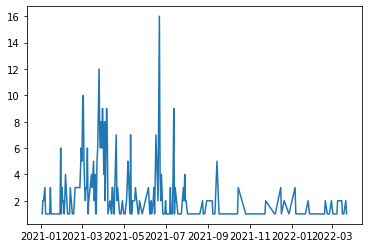

In [116]:
import matplotlib.pyplot as plt
plt.plot(count["Date"], count["counts"])